#### The goal of this notebook is to show a user several basic PySpark commands and to calculate ...

In [8]:
%load_ext autoreload
%autoreload

#%autoreload
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

from timeUtils import clock, elapsed

import os
import findspark
import random

import pandas as pd
pd.set_option("display.max_rows",1000)
pd.set_option('precision', 3)

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup Java

In [9]:
javahome=os.environ.get("JAVA_HOME")
print("JAVA_HOME -->",javahome)
## This should point to something that has 'whatever.jdk1.8.whatever' in the path. If not, nothing will work.

JAVA_HOME --> /Library/Java/JavaVirtualMachines/jdk1.8.0_241.jdk/Contents/Home


# Setup Spark

In [3]:
def setupSpark(debug=False):
    import os
    try:
        javahome=os.environ.get("JAVA_HOME")
        print("Java home is {0}".format(javahome))
    except:
        raise ValueError("There is not JAVA_HOME variable")
        
    try:
        sparkhome=os.environ.get("SPARK_HOME")
        print("Spark home is {0}".format(sparkhome))
    except:
        raise ValueError("There is not SPARK_HOME variable")
    
    try:
        import findspark
        findspark.init(sparkhome)
    except:
        raise ValueError("Could import findspark")
        
    try:
        import pyspark    
    except:
        raise ValueError("Could not import pyspark")
    
    conf = (pyspark.SparkConf()
        .setAppName('My Spark Application')
#        .setMaster('yarn')
        .set('spark.driver.memory', '120g')
        .set('spark.shuffle.service.enabled', True)
        .set('spark.dynamicAllocation.enabled', True)
#        .set('spark.executor.heartbeatInterval', '3600s')
#        .set('spark.executor.memory', '5g')
#        .set('spark.yarn.executor.memoryOverhead', '4000m')
        .set('spark.dynamicAllocation.maxExecutors', 250)
#        .set('spark.dynamicAllocation.minExecutors', 10)
        .set('spark.kryoserializer.buffer.max', '2047m')
        .set('spark.speculation', True)
        .set('spark.sql.execution.arrow.enabled', False)
#        .set('spark.jars', hivejar)
        .set('spark.port.maxRetries', 100)
        .set('spark.driver.maxResultSize', '20g')
        .set('spark.sql.broadcastTimeout', 600))
            
# VT Stuff        
#        .set("fs.adl.oauth2.access.token.provider.type","ClientCredential")
#        .set("fs.adl.oauth2.client.id","4e7f6eec-d974-4d85-9997-1288d01bf6c5")
#        .set("fs.adl.oauth2.credential","dJ8W3bZ9QR9-alR:TgTX-H.v2hDFVwIS")
#        .set("fs.adl.oauth2.refresh.url","https://login.microsoftonline.com/8a7197be-6a57-442c-b24c-ba9cf03dab93/oauth2/token"))
    
    sc = pyspark.SparkContext(conf = conf)
    sc.setLogLevel('ERROR')
    
    return sc


#from pyspark import SparkContext

In [4]:
def setupHive(sc):
    from pyspark.sql import HiveContext
    hc = HiveContext(sc)
    return hc
    
def setupSQL(sc):
    from pyspark.sql import SQLContext
    sqlc = SQLContext(sc)
    return sqlc

In [5]:
sc = setupSpark(debug=True)

Java home is /Library/Java/JavaVirtualMachines/jdk1.8.0_241.jdk/Contents/Home
Spark home is /Users/tgadfort/spark-2.4.4-bin-hadoop2.7


In [6]:
hc   = setupHive(sc)
sqlc = setupSQL(sc)

# Hello World For Spark

In [78]:
from pyspark import SparkContext
from operator import add
 
data = sc.parallelize(list("Hello World"))
counts = data.map(lambda x: (x, 1)).reduceByKey(add).sortBy(lambda x: x[1], ascending=False).collect()
for (word, count) in counts:
    print("{}: {}".format(word, count))
sc.stop()

l: 3
o: 2
H: 1
W: 1
e: 1
d: 1
 : 1
r: 1


# Odd Number Generator

In [11]:
start, cmt = clock("Testing Odd Number Generator")
big_list = range(10000)
rdd = sc.parallelize(big_list, 2)
odds = rdd.filter(lambda x: x % 2 != 0)
elapsed(start, cmt)

odds.take(5)

Current Time is Tue Feb 18, 2020 13:50:47 for Testing Odd Number Generator
Current Time is Tue Feb 18, 2020 13:50:47 for Done with Testing Odd Number Generator
Process [Done with Testing Odd Number Generator] took 4.0 millseconds.


[1, 3, 5, 7, 9]

# Pi Estimation

In [ ]:
def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

In [ ]:
N = int(5e7)
N = 50000000
#N = 10

In [ ]:
start, cmt = clock("Testing Python with {0} events".format(N))
pcount = sum(map(inside, range(0, N)))
print("Pi is roughly %f" % (4.0 * pcount / N))
elapsed(start, cmt)

In [ ]:
start, cmt = clock("Testing PySpark with {0} events".format(N))
count = sc.parallelize(range(0, N)).filter(inside).count()
print("Pi is roughly %f" % (4.0 * count / N))
elapsed(start, cmt)

# DataFrame Example

In [12]:
from ioUtils import getFile
moviedata = getFile("/Users/tgadfort/Documents/code/network_lunch_and_learn/data.p")
moviedata.head()

,Title,Actor,Year,Award
3,Valdemar Sejr,Peter Malberg,1910,NaN
4,Valdemar Sejr,Ellen Gottschalch,1910,NaN
7,Ekspeditricen,Clara Pontoppidan,1911,NaN
8,Ekspeditricen,Thorkild Roose,1911,NaN
11,Par habitude,Maurice Chevalier,1911,NaN


In [16]:
# Enable Arrow-based columnar data transfers
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Create a Spark DataFrame from a pandas DataFrame
start, cmt = clock("Creating IMDB Spark DataFrame")
spdf = hc.createDataFrame(moviedata)
spdf.cache()
elapsed(start, cmt)

Current Time is Tue Feb 18, 2020 13:51:55 for Creating IMDB Spark DataFrame
Current Time is Tue Feb 18, 2020 13:51:58 for Done with Creating IMDB Spark DataFrame
Process [Done with Creating IMDB Spark DataFrame] took 3 seconds.


In [18]:
from pyspark.sql.functions import countDistinct, col, max, min
print("Total Rows = {0}".format(spdf.count()))
print("Total Cols = {0}".format(len(spdf.columns)))
spdf.agg(countDistinct("Actor")).show()
spdf.agg(min(col("Year"))).show()
spdf.agg(max(col("Year"))).show()

Total Rows = 132236
Total Cols = 4
+---------------------+
|count(DISTINCT Actor)|
+---------------------+
|                11123|
+---------------------+

+---------+
|min(Year)|
+---------+
|     1910|
+---------+

+---------+
|max(Year)|
+---------+
|     2027|
+---------+



### Count Number of Rows with Column Value (i.e., how many movies were made each year) 

In [32]:
spdf.groupBy('Year').count().show(3)
## Somewhat equivalent Pandas command
moviedata.groupby('Year').size().head(3)

+----+-----+
|Year|count|
+----+-----+
|1950| 1448|
|1919|  163|
|1936| 1442|
+----+-----+
only showing top 3 rows



Year
1910    3
1911    5
1912    1
dtype: int64

#### Try Actor/Actress With The Most Films

In [30]:
result = spdf.groupBy('Actor').count() \
             .filter("`count` >= 10") \
             .sort(col("count").desc())

#### Spark won't compute anything until it needs to show it

In [33]:
result.show(5)

+----------------+-----+
|           Actor|count|
+----------------+-----+
|    Eric Roberts|  144|
|Gérard Depardieu|  129|
|      John Wayne|  113|
|       Jack Holt|  113|
|  Michel Piccoli|  111|
+----------------+-----+
only showing top 5 rows



#### Try Caching Result And See Speed Increase

In [36]:
result = result.cache()

In [38]:
result.show(5)

+----------------+-----+
|           Actor|count|
+----------------+-----+
|    Eric Roberts|  144|
|Gérard Depardieu|  129|
|       Jack Holt|  113|
|      John Wayne|  113|
|  Michel Piccoli|  111|
+----------------+-----+
only showing top 5 rows



# Spark SQL (Using KDD '99 Data)

#### Load 2MB GZIP File With KDD Data

In [45]:
start, cmt = clock("Creating Spark DataFrame From GZIP -> RDD -> Rows -> Spark")

Current Time is Tue Feb 18, 2020 14:06:58 for Creating Spark DataFrame From GZIP -> RDD -> Rows -> Spark


In [46]:
data_file = "kddcup.data_10_percent.gz"
raw_rdd = sc.textFile(data_file).cache()
raw_rdd.take(1)

['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.']

#### Creating a Spark DataFrame Directly From The RDD

In [47]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
csv_rdd.take(1)

[['0',
  'tcp',
  'http',
  'SF',
  '181',
  '5450',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '8',
  '8',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '9',
  '9',
  '1.00',
  '0.00',
  '0.11',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  'normal.']]

#### Create List of Spark Rows From Split CSV Data

In [48]:
from pyspark.sql import Row

#pddf.columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]), 
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    logged_in=int(r[11]),
    num_compromised=int(r[12]),
    root_shell=int(r[13]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    num_shells=int(r[17]),
    num_access_files=int(r[18]),
    num_outbound_cmds=int(r[19]),
    is_host_login=int(r[20]),
    is_guest_login=int(r[21]),
    count=int(r[22]),
    srv_count=int(r[23]),
    serror_rate=float(r[24]),
    srv_serror_rate=float(r[25]),
    rerror_rate=float(r[26]),
    srv_rerror_rate=float(r[27]),
    same_srv_rate=float(r[28]),
    diff_srv_rate=float(r[29]),
    srv_diff_host_rate=float(r[30]),
    dst_host_count=int(r[31]),
    dst_host_srv_count=int(r[32]),
    dst_host_same_srv_rate=float(r[33]),
    dst_host_diff_srv_rate=float(r[34]),
    dst_host_same_src_port_rate=float(r[35]),
    dst_host_srv_diff_host_rate=float(r[36]),
    dst_host_serror_rate=float(r[37]),
    dst_host_srv_serror_rate=float(r[38]),
    dst_host_rerror_rate=float(r[39]),
    dst_host_srv_rerror_rate=float(r[40]),
    label=r[-1]
    )
)
parsed_rdd.take(1)

[Row(count=8, diff_srv_rate=0.0, dst_bytes=5450, dst_host_count=9, dst_host_diff_srv_rate=0.0, dst_host_rerror_rate=0.0, dst_host_same_src_port_rate=0.11, dst_host_same_srv_rate=1.0, dst_host_serror_rate=0.0, dst_host_srv_count=9, dst_host_srv_diff_host_rate=0.0, dst_host_srv_rerror_rate=0.0, dst_host_srv_serror_rate=0.0, duration=0, flag='SF', hot=0, is_guest_login=0, is_host_login=0, label='normal.', logged_in=1, num_access_files=0, num_compromised=0, num_failed_logins=0, num_file_creations=0, num_outbound_cmds=0, num_root=0, num_shells=0, protocol_type='tcp', rerror_rate=0.0, root_shell=0, same_srv_rate=1.0, serror_rate=0.0, service='http', src_bytes=181, srv_count=8, srv_diff_host_rate=0.0, srv_rerror_rate=0.0, srv_serror_rate=0.0, su_attempted='0', urgent=0, wrong_fragment=0)]

In [49]:
spdf = sqlc.createDataFrame(parsed_rdd)
print("Total Rows = {0}".format(spdf.count()))
print("Total Cols = {0}".format(len(spdf.columns)))

Total Rows = 494021
Total Cols = 41


In [50]:
elapsed(start, cmt)

Current Time is Tue Feb 18, 2020 14:07:09 for Done with Creating Spark DataFrame From GZIP -> RDD -> Rows -> Spark
Process [Done with Creating Spark DataFrame From GZIP -> RDD -> Rows -> Spark] took 10 seconds.


#### Load GZIP Data And Convert To Python String Object

In [51]:
start, cmt = clock("Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark")

Current Time is Tue Feb 18, 2020 14:07:52 for Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark


In [52]:
import gzip
gbuffer    = gzip.open("kddcup.data_10_percent.gz", 'rb') ## Returns a Buffer
gbytesdata = gbuffer.read()  ## Reads the data into a `bytes` object
gstrdata   = gbytesdata.decode("utf-8")  ## Decode the 'encoded' btyes object using UTF-8. It's now a string object
print("1st 50 Characters  ==>  {0}".format(gstrdata[:50]))

1st 50 Characters  ==>  0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Create Pandas DataFrame From CSV String

In [53]:
from pandas import DataFrame
splitdata = gstrdata.split("\n")
splitdata = [x.split(",") for x in splitdata]
pddf = DataFrame(splitdata)
pddf.columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
elapsed(start, cmt)

Current Time is Tue Feb 18, 2020 14:08:01 for Done with Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark
Process [Done with Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark] took 8 seconds.


#### Create Spark DataFrame From Pandas DataFrame

In [54]:
spdf = hc.createDataFrame(pddf)
print("Total Rows = {0}".format(spdf.count()))
print("Total Cols = {0}".format(len(spdf.columns)))

Total Rows = 494022
Total Cols = 42


In [55]:
elapsed(start, cmt)

Current Time is Tue Feb 18, 2020 14:09:36 for Done with Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark
Process [Done with Creating Spark DataFrame From GZIP -> CSV -> Pandas -> Spark] took 1.7 minutes.


## KDD '99 Spark DataFrame SQL Access 

#### Collect results using PySpark statements

In [56]:
protocols = spdf.groupBy('protocol_type').count().orderBy('count', ascending=False)
protocols.show()

+-------------+------+
|protocol_type| count|
+-------------+------+
|         icmp|283602|
|          tcp|190065|
|          udp| 20354|
|         null|     1|
+-------------+------+



#### Collect results using SQL statements

In [57]:
spdf.registerTempTable("connections")  ## Must register the DataFrame as a Table (Temp)

In [58]:
protocols = sqlc.sql("""SELECT protocol_type, count(*) as freq
                        FROM connections
                        GROUP BY protocol_type
                        ORDER BY 2 DESC
                        """)
protocols.show()

+-------------+------+
|protocol_type|  freq|
+-------------+------+
|         icmp|283602|
|          tcp|190065|
|          udp| 20354|
|         null|     1|
+-------------+------+



In [ ]:
attack_protocol = sqlc.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as freq
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
attack_protocol.show()

In [ ]:
attack_stats = sqlc.sql("""
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM connections
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC
                           """)
attack_stats.show()

In [ ]:
attack_stats_df = attack_stats.toPandas()
attack_stats_df

# Running Python Code In PySpark

In [71]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Load a CSV with header and ';' delimiter
spdf = spark.read.load("bank.csv", format="csv", sep=";", inferSchema="true", header="true", quote="\"")
spdf.show(1)

+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|       job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
only showing top 1 row



In [65]:
def squareF(z):
    try:
        return z**2
    except:
        return None

def squareFconv(z):
    try:
        return float(z**2)
    except:
        return None


def square(z):
    try:
        return z**2
    except:
        return None


## Import UDF From PySpark Functions
from pyspark.sql.functions import udf
## Import Types
from pyspark.sql.types import FloatType, IntegerType


## Create 3 UDFs
square_udf_int = udf(lambda z: square(z), IntegerType())
square_udf_float = udf(lambda z: squareF(z), FloatType())
square_udf_float_conv = udf(lambda z: squareFconv(z), FloatType())

#### Show Only Certain Columns of PySpark DataFrame

In [70]:
spdf.select(["age", "education", "balance"]).show(5)

+---+---------+-------+
|age|education|balance|
+---+---------+-------+
| 30|  primary|   1787|
| 33|secondary|   4789|
| 35| tertiary|   1350|
| 30| tertiary|   1476|
| 59|secondary|      0|
+---+---------+-------+
only showing top 5 rows



##### Apply The "Square an Integer" UDF to the 'Age' column

In [72]:
dummy = spdf.withColumn('ageSquared', square_udf_int('age'))
dummy.select(["age", "education", "balance", "ageSquared"]).show(5)

+---+---------+-------+----------+
|age|education|balance|ageSquared|
+---+---------+-------+----------+
| 30|  primary|   1787|       900|
| 33|secondary|   4789|      1089|
| 35| tertiary|   1350|      1225|
| 30| tertiary|   1476|       900|
| 59|secondary|      0|      3481|
+---+---------+-------+----------+
only showing top 5 rows



##### Apply The "Square an Integer" UDF to the 'Eduction' column

In [73]:
dummy = spdf.withColumn('eductionSquared', square_udf_int('education'))
dummy.select(["age", "education", "balance", "eductionSquared"]).show(5)

+---+---------+-------+---------------+
|age|education|balance|eductionSquared|
+---+---------+-------+---------------+
| 30|  primary|   1787|           null|
| 33|secondary|   4789|           null|
| 35| tertiary|   1350|           null|
| 30| tertiary|   1476|           null|
| 59|secondary|      0|           null|
+---+---------+-------+---------------+
only showing top 5 rows



##### Apply The "Square a Float" UDF to the 'Balance' column

In [74]:
dummy = spdf.withColumn('balanceSquared', square_udf_float('balance'))
dummy.select(["age", "education", "balance", "balanceSquared"]).show(5)

+---+---------+-------+--------------+
|age|education|balance|balanceSquared|
+---+---------+-------+--------------+
| 30|  primary|   1787|          null|
| 33|secondary|   4789|          null|
| 35| tertiary|   1350|          null|
| 30| tertiary|   1476|          null|
| 59|secondary|      0|          null|
+---+---------+-------+--------------+
only showing top 5 rows



##### Apply The "Square a Float and Force Conversion to Type Float" UDF to the 'Balance' column

In [75]:
dummy = spdf.withColumn('balanceConvSquared', square_udf_float_conv('balance'))
dummy.select(["age", "education", "balance", "balanceConvSquared"]).show(5)

+---+---------+-------+------------------+
|age|education|balance|balanceConvSquared|
+---+---------+-------+------------------+
| 30|  primary|   1787|         3193369.0|
| 33|secondary|   4789|        2.293452E7|
| 35| tertiary|   1350|         1822500.0|
| 30| tertiary|   1476|         2178576.0|
| 59|secondary|      0|               0.0|
+---+---------+-------+------------------+
only showing top 5 rows



# Using MLlib

In [86]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Load a CSV with header and ';' delimiter
spdf = spark.read.load("bank.csv", format="csv", sep=";", inferSchema="true", header="true", quote="\"")
cols = spdf.columns

In [87]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [88]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(spdf)
spdf = pipelineModel.transform(spdf)
selectedCols = ['label', 'features'] + cols
df = spdf.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [89]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3173
Test Dataset Count: 1348


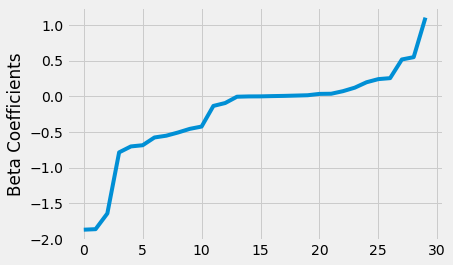

In [90]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)


#We can obtain the coefficients by using LogisticRegressionModel’s attributes.

import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [108]:
trainingSummary = lrModel.summary
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Training set areaUnderROC: 0.8871696776478928


# K-Means Clustering

### Generate some random "blobs" for clustering

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

nCenters = 25

for (n_samples, name) in [(int(1e5), "small.csv"), (int(1e6), "mid.csv"), (int(3e6), "large.csv")]:
    n_features=3
    X, y = make_blobs(n_samples=n_samples, centers=nCenters, n_features=n_features, random_state=42)
    if name == "small.csv":
        plotData = [X, y]

    # add a row index as a string
    pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
    pddf['id'] = 'row'+pddf.index.astype(str)

    #move it first (left)
    cols = list(pddf)
    cols.insert(0, cols.pop(cols.index('id')))
    pddf = pddf.ix[:, cols]
    pddf.head()

    # save the ndarray as a csv file
    print("Saving {0} data values to {1}".format(n_samples, name))
    pddf.to_csv(name, index=False)

Saving 100000 data values to small.csv
Saving 1000000 data values to mid.csv
Saving 3000000 data values to large.csv


### Plot data to see what we generated

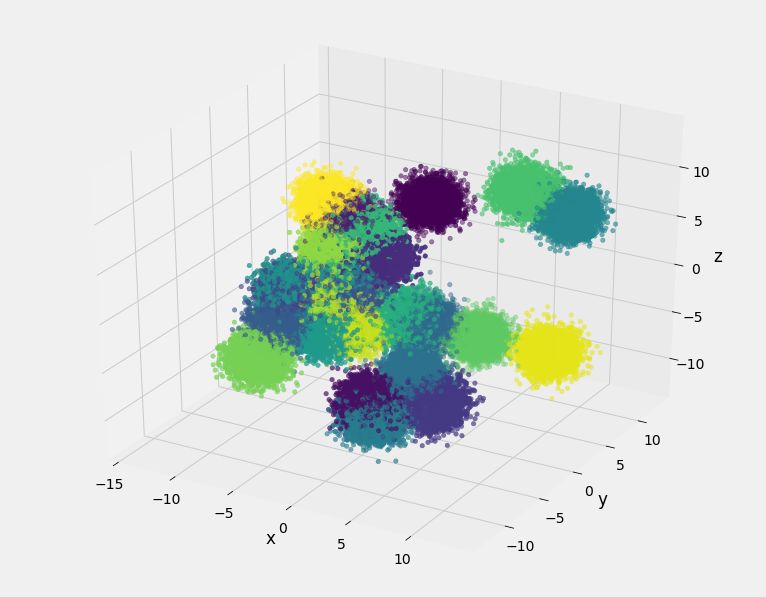

In [256]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(plotData[0][:,0], plotData[0][:,1], plotData[0][:,2], c=plotData[1])
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

## KMeans Clustering With PySpark

In [274]:
csvfile = "small.csv"
plotClusters = False
start, cmt = clock("Running KMeans With PySpark")

Current Time is Wed Feb 19, 2020 11:53:24 for Running KMeans With PySpark


In [275]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Load a CSV with header and ';' delimiter
spdf = spark.read.load(csvfile, format="csv", sep=",", inferSchema="true", header="true") #, quote="\"")
cols = spdf.columns
FEATURES_COL = ['x', 'y', 'z']
print(spdf.dtypes)
spdf.show(3)

[('id', 'string'), ('x', 'double'), ('y', 'double'), ('z', 'double')]
+----+-------------------+------------------+-----------------+
|  id|                  x|                 y|                z|
+----+-------------------+------------------+-----------------+
|row0| -3.215065179214845|-4.616712992009834|5.474539109260251|
|row1|-1.7454481358227234|  5.32195918297932|-5.32828523998774|
|row2| -8.511099311677444| 8.915971070992285|2.012875250392181|
+----+-------------------+------------------+-----------------+
only showing top 3 rows



#### Set Format For MLlib

In [276]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
spdf_kmeans = vecAssembler.transform(spdf).select('id', 'features')
spdf_kmeans.show(3)

+----+--------------------+
|  id|            features|
+----+--------------------+
|row0|[-3.2150651792148...|
|row1|[-1.7454481358227...|
|row2|[-8.5110993116774...|
+----+--------------------+
only showing top 3 rows



#### Run a 'cost' analysis to determine optimal number of clusters

In [277]:
## Runs Spark KMeans
runCost = False
if runCost is True:
    cost = np.zeros(20)
    for k in range(2,20):
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(spdf_kmeans.sample(False,0.1, seed=42))
        cost[k] = model.computeCost(spdf_kmeans) # requires Spark 2.0 or later


    fig, ax = plt.subplots(1,1, figsize =(8,6))
    ax.plot(range(2,20),cost[2:20])
    ax.set_xlabel('k')
    ax.set_ylabel('cost')

#### Choose 10 clusters because that's what we actually generated

In [278]:
k = nCenters
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(spdf_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 0.28613686  1.8485666  -9.07147425]
[9.35161495 9.32550589 6.06066347]
[-2.19050511 -4.20040634  1.55622424]
[ 9.74011686  5.44557788 -6.01990595]
[-1.22620585 -7.51019216 -0.09934493]
[5.91605872 8.32517324 8.56287559]
[ 4.16366633 -9.59547146  9.39621933]
[-8.78485982  8.0312792  -4.17350684]
[ 3.2174263  -3.76938549  0.42461635]
[ 2.16311983 -6.56048939 -8.88418882]
[-0.88564125  5.70280246 -6.00627407]
[-9.36970078  6.81628786  3.08914159]
[-7.1729372   6.03356486 -8.52305943]
[ 1.94449269 -6.91126494 -6.69028698]
[-6.09396406 -9.05157067 -3.50554915]
[-2.51364454  9.01740724  4.63694767]
[ 1.96750236  8.44180986 -8.23117298]
[4.7580277  9.07614036 7.62228791]
[-2.2005821  -4.55951377  6.51306576]
[-6.80595954 -4.01780167 -1.15655181]
[7.26661999 9.23132609 6.70521857]
[ 0.93379547 -6.29430988  9.39852004]
[ 6.64943431 -5.74912321 -6.36271879]
[-3.92468661 -8.02114579  3.67190568]
[-9.80340136  8.3262732  -5.40984525]


#### Predict cluster for generated data

In [279]:
transformed = model.transform(spdf_kmeans).select('id', 'prediction')
rows = transformed.collect()

spdf_pred = spark.createDataFrame(rows)
spdf_pred.show(5)

+----+----------+
|  id|prediction|
+----+----------+
|row0|        18|
|row1|        10|
|row2|        11|
|row3|        10|
|row4|        16|
+----+----------+
only showing top 5 rows



#### Join with generated data

In [280]:
spdf_pred = spdf_pred.join(spdf, 'id')
spdf_pred.show(5)

+----------+----------+------------------+-------------------+------------------+
|        id|prediction|                 x|                  y|                 z|
+----------+----------+------------------+-------------------+------------------+
|row1000096|         3| 8.070867805034647|  5.550299797190014| -5.41344961812661|
|row1000669|        19| -6.29276368892843| -4.033689407351056|-0.790950022819588|
| row100093|        22| 7.166382056879568| -5.936760952944399|-7.055108771624883|
|row1000973|        13|0.8995025150734803| -6.293107662467106|-7.721869984870177|
|row1001244|        19|-6.225315243545247|-3.4504983482568474|0.5440911068236218|
+----------+----------+------------------+-------------------+------------------+
only showing top 5 rows



#### Convert to Pandas and set index

In [281]:
pddf_pred = spdf_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
row1000096,3,8.071,5.550,-5.413
row1000669,19,-6.293,-4.034,-0.791
row100093,22,7.166,-5.937,-7.055
row1000973,13,0.900,-6.293,-7.722
row1001244,19,-6.225,-3.450,0.544


#### Plot everything

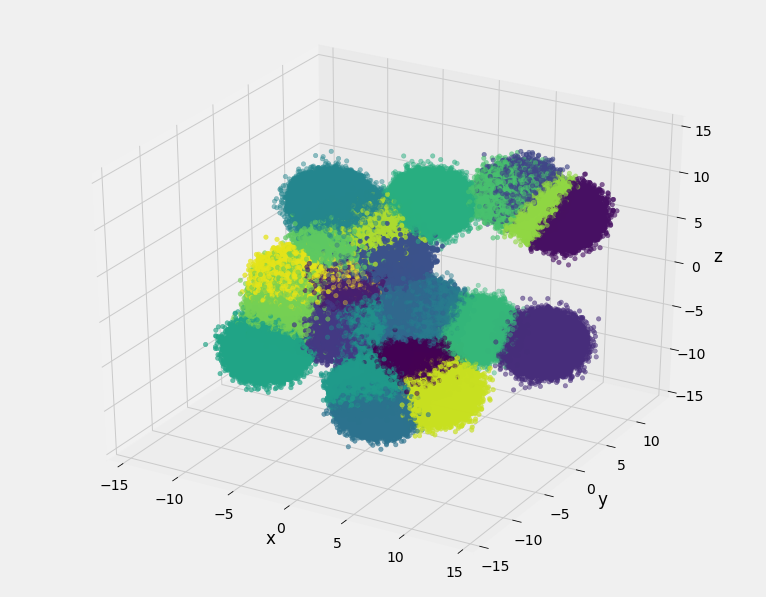

In [282]:
if plotClusters:
    threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
    threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
    threedee.set_xlabel('x')
    threedee.set_ylabel('y')
    threedee.set_zlabel('z')
    plt.show()

In [283]:
elapsed(start, cmt)

Current Time is Wed Feb 19, 2020 12:05:13 for Done with Running KMeans With PySpark
Process [Done with Running KMeans With PySpark] took 11.8 minutes.


In [284]:
## Just sleep to cool off
from time import sleep
sleep(2)

## KMeans Clustering With Sklean + Pandas (For Comparison)

In [285]:
#csvfile = "small.csv"
start, cmt = clock("Running KMeans With Sklean + Pandas")

Current Time is Wed Feb 19, 2020 12:05:15 for Running KMeans With Sklean + Pandas


In [286]:
from pandas import read_csv
clusterData = read_csv(csvfile)
clusterData.index = clusterData['id']
clusterData.drop(['id'], axis=1, inplace=True)
clusterData.head()

,x,y,z
id,,,
row0,-3.215,-4.617,5.475
row1,-1.745,5.322,-5.328
row2,-8.511,8.916,2.013
row3,-1.216,5.769,-4.342
row4,2.764,7.618,-7.727


#### Create clusters and predict

In [287]:
from sklearn.cluster import KMeans as SklearnKMeans
kmeans = SklearnKMeans(n_clusters=nCenters)
kmeans.fit(clusterData)
y_kmeans = kmeans.predict(clusterData)

#### Join everything together

In [288]:
from pandas import Series
pddf_pred_sk = DataFrame(y_kmeans, index=clusterData.index)
pddf_pred_sk.columns = ['prediction']
pddf_pred_sk = pddf_pred_sk.join(clusterData) ## This works because we have identical indices
pddf_pred_sk.head()

,prediction,x,y,z
id,,,,
row0,23,-3.215,-4.617,5.475
row1,11,-1.745,5.322,-5.328
row2,6,-8.511,8.916,2.013
row3,11,-1.216,5.769,-4.342
row4,1,2.764,7.618,-7.727


#### Same plot, but doing it all with Pandas + Sklean

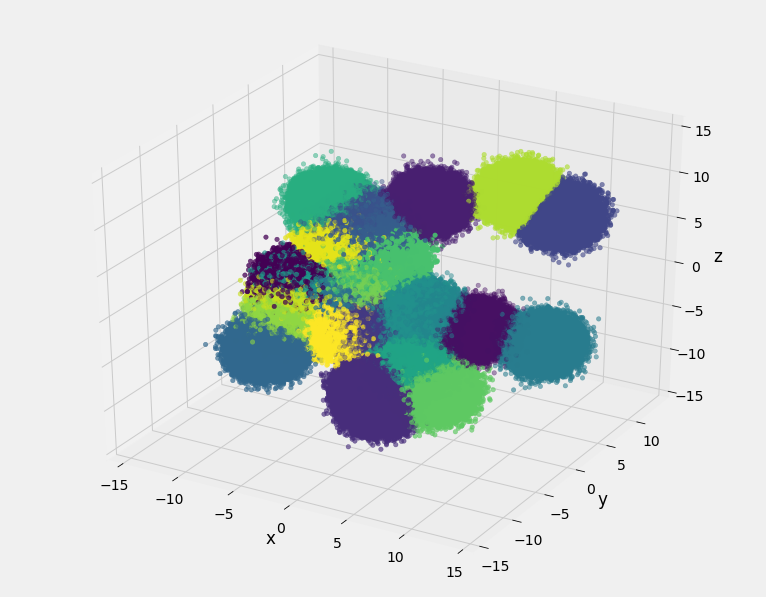

In [289]:
if plotClusters:
    threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
    threedee.scatter(pddf_pred_sk.x, pddf_pred_sk.y, pddf_pred_sk.z, c=pddf_pred_sk.prediction)
    threedee.set_xlabel('x')
    threedee.set_ylabel('y')
    threedee.set_zlabel('z')
    plt.show()

In [290]:
elapsed(start, cmt)

Current Time is Wed Feb 19, 2020 12:11:35 for Done with Running KMeans With Sklean + Pandas
Process [Done with Running KMeans With Sklean + Pandas] took 6.3 minutes.
